### Project Summary   
**  Overview **: This project aims to build up classification models for the cat and dog owners from text comments. There are around 6,000,000 comments recorded in the dataset and the dataset itself is unlabeled. Each data row will have an userid, an text comment and belongs to one channel. 

** Details ** : 
1. Searched specific terms which a cat/dog owner might have, and label those users as dog&cat owners.  Also labeled users who don't have pets as those whose comments don't contain any specific terms.  By this way, we turn our dataset into labeled ones and convert problem from unsupervised to supervised.   
2. Use RegexTokenizer to tokenize text comments.
       * RegexTokenizer allows more advanced tokenization based on regular expression (regex) matching. By default, the parameter “pattern” is used as delimiters to split the input text. Alternatively, users can set parameter “gaps” to false indicating the regex “pattern” denotes “tokens” rather than splitting gaps, and find all matching occurrences as the tokenization result.  
3. Use Word2Vec represent text features as vectors. 
4. Train Logistic regression model and random forest model to classify audiences. Evaluation metrics are include: precision, recall, accuracy, AUC. Based on my analysis (I only randomly pick a small portion of dataset for training in order to speed process up)  random forest outperforms LR model.
5. Use our trained model to predict all users in the dataset. And get statistical sense of how dog&cat owners' distribution.  Extract word frequency to see related topics regards to those owner.

#### 0. Data Exploration and Cleaning

In [0]:
# read data
df = spark.read.load("/FileStore/tables/animals_comments.csv", format='csv', header = True, inferSchema = True)
df.show(10)

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
+--------------------+------+-------------------------------------+
only showing top 10 rows

In [0]:
#check columns's datatype 
df.dtypes

Out[3]: [('creator_name', 'string'), ('userid', 'double'), ('comment', 'string')]

In [0]:
print("Number of rows in df:", df.count())

Number of rows in df: 5820035

In [0]:
# Count null values in each columns 
print('Number of null values in creator_name: ',df.filter(df['creator_name'].isNull()).count())
print('Number of null values in userid: ',df.filter(df['userid'].isNull()).count())
print('Number of null values in comment: ',df.filter(df['comment'].isNull()).count())

Number of null values in creator_name: 32050
Number of null values in userid: 565
Number of null values in comment: 1051

In [0]:
#drop out rows with no comments and no userid
def pre_process(df):
  df_drop = df.filter(df['comment'].isNotNull())
  df_drop = df_drop.filter(df_drop['userid'].isNotNull())
  df_drop = df_drop.dropDuplicates()
  
  print('After dropping, we have ', str(df_drop.count()), 'row in dataframe')
  return df_drop

df_drop = pre_process(df)

After dropping, we have 5757212 row in dataframe

In [0]:
import pyspark.sql.functions as F
#convert text in comment to lower case.
df_clean = df_drop.withColumn('comment', F.lower(F.col('comment')))

In [0]:
display(df_clean)

creator_name,userid,comment
Brian Barczyk,28322.0,since i watched these snake videos i am not afraid of snakes anymore and now i really want a snake for my birthday
WaysideWaifs,89939.0,why are humans so inhuman...
Brian Barczyk,2487844.0,didnt you have an anaconda before?
Brian Barczyk,2487844.0,definitely go to indonesia! would love to see those vlogs!
The Dodo,2488940.0,how many cats are there....
MonkeyBoo,2530479.0,now all he needs is a yellow hat
꼬부기아빠 My Pet Diary,2538155.0,와...완전 대박 좋아요...♥
ViralHog,42559.0,sad you guys cant understand the video properly. the snake was not attacking he was just crossing the road and when he saw the vehicle coming toward itself he got scared and tried to run while jumping out of the way but now hes dead !
Dan Hiteshew,2427873.0,awesome dan.
Real Fish Talk,2427873.0,fish rule


##### This is an unlabeled dataset and we want to train a clasifier to identify cat and dog owners. Thus first thing to do is to label each comment. 
1. Label comment when he/she has dogs or cats.   
2. label comment when he/she don't have a dog or cat.   
3.  Combine 1 and 2 as our training dataset, and rest of the dataset will be the data we predict.   
4. The strategy to tell if a user own or not own is just using key words (like I have a dog) to tell. Otherwise we can't have better ways and don't have labels.

In [0]:
# find user with preference of dog and cat
# note: please propose your own approach and rule to label data 
cond = (df_clean["comment"].like("%my dog%") | df_clean["comment"].like("%i have a dog%")\
        | df_clean["comment"].like("%my cat%") | df_clean["comment"].like("%i have a cat%") \
        | df_clean["comment"].like("%my dogs%") | df_clean["comment"].like("%my cats%")\
        | df_clean["comment"].like("%my cat%") | df_clean["comment"].like("%i have dogs%")\
        | df_clean["comment"].like("%i have cats%") | df_clean["comment"].like("%my puppy%")\
        | df_clean["comment"].like("%my kitten%") | df_clean["comment"].like("%i have a puppy%")\
        | df_clean["comment"].like("%i have puppies%"))

df_clean = df_clean.withColumn('dog_cat',  cond)

# find user do not have 
df_clean = df_clean.withColumn('no_pet', ~df_clean["comment"].like("%my%") & ~df_clean["comment"].like("%have%") & ~df_clean["comment"].like("%my dog%") \
                              & ~df_clean["comment"].like("%my cat%")) 


In [0]:
df_clean.show(10)

+-----------------------+--------+------------------------+-------+------+
 creator_name| userid| comment|dog_cat|no_pet|
+-----------------------+--------+------------------------+-------+------+
 Brian Barczyk| 28322.0| since i watched t...| false| false|
 WaysideWaifs| 89939.0| why are humans so...| false| true|
 TobyTurner|236731.0| roses are red thi...| false| false|
 meow meow|260511.0| ..omai-wa.*reject...| false| true|
 Brave Wilderness|420830.0| good job on getti...| false| true|
꼬부기아빠 My Pet Diary|459543.0|2!!0!!!만명!!!!! 축하...| false| true|
 The Dodo|485503.0| who gave thumbs d...| false| true|
 Hope For Paws - O...|504270.0| such an intense r...| false| true|
 Viktor Larkhill|542233.0| oh that poor cat!!| false| true|
 Brave Wilderness|543795.0| you can live your...| false| true|
+-----------------------+--------+------------------------+-------+------+
only showing top 10 rows

#### 1. Build the classifier 
In order to train a model against the comments, you can use RegexTokenizer to split each comment into a list of words and then use Word2Vec or other model to convert the list to a word vector. What Word2Vec does is to map each word to a unique fixed-size vector and then transform each document into a vector using the average of all words in the document.

In [0]:
# data preprocessing 
from pyspark.ml.feature import RegexTokenizer

regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="text", pattern="\\W")
df_clean = regexTokenizer.transform(df_clean)
df_clean.show(10)

+-----------------------+--------+------------------------+-------+------+--------------------+
 creator_name| userid| comment|dog_cat|no_pet| text|
+-----------------------+--------+------------------------+-------+------+--------------------+
 Brian Barczyk| 28322.0| since i watched t...| false| false|[since, i, watche...|
 WaysideWaifs| 89939.0| why are humans so...| false| true|[why, are, humans...|
 TobyTurner|236731.0| roses are red thi...| false| false|[roses, are, red,...|
 meow meow|260511.0| ..omai-wa.*reject...| false| true|[omai, wa, reject...|
 Brave Wilderness|420830.0| good job on getti...| false| true|[good, job, on, g...|
꼬부기아빠 My Pet Diary|459543.0|2!!0!!!만명!!!!! 축하...| false| true| [2, 0]|
 The Dodo|485503.0| who gave thumbs d...| false| true|[who, gave, thumb...|
 Hope For Paws - O...|504270.0| such an intense r...| false| true|[such, an, intens...|
 Viktor Larkhill|542233.0| oh that poor cat!!| false| true|[oh, that, poor, ...|
 Brave Wilderness|543795.0| you can live your...| false| true|[you, can, live, ...|
+-----------------------+--------+------------------------+-------+------+--------------------+
only showing top 10 rows

####Optional: only select 1000000 rows for testing. (In final version, try to use all dataset)

In [0]:
from pyspark.sql.functions import rand 

df_clean.orderBy(rand(seed=0)).createOrReplaceTempView("table1")
df_clean = spark.sql("select * from table1 limit 1000000")

In [0]:
# use word2vec get text vector feature.
from pyspark.ml.feature import Word2Vec
# Learn a mapping from words to Vectors. (choose higher vectorSize here)
#word2Vec = Word2Vec(vectorSize=20, minCount=1, inputCol="text", outputCol="wordVector")
word2Vec = Word2Vec(vectorSize=50, minCount=1, inputCol="text", outputCol="wordVector")
model = word2Vec.fit(df_clean)

df_model = model.transform(df_clean)
df_model.show(10)

+------------------+---------+--------------------+-------+------+--------------------+--------------------+
 creator_name| userid| comment|dog_cat|no_pet| text| wordVector|
+------------------+---------+--------------------+-------+------+--------------------+--------------------+
Taylor Nicole Dean|2055096.0|call it gucci bec...| false| true|[call, it, gucci,...|[0.06418509362265...|
 The Hoover Boys| 963990.0|nice work!! pocke...| false| true|[nice, work, pock...|[-0.0767619647085...|
 The Dodo|1112358.0|and then it got e...| false| true|[and, then, it, g...|[-0.0853821899121...|
 Info Marvel|1200788.0|me encanto este v...| false| true|[me, encanto, est...|[0.21255011856555...|
 Brave Wilderness| 878896.0|hello coyote!im h...| false| false|[hello, coyote, i...|[-0.0317005375685...|
 Brave Wilderness|1331468.0|try this when yo...| false| true|[try, this, when,...|[-0.1295940073207...|
 Robin Seplut| 827037.0|gbn logre a fvcf...| false| true|[gbn, logre, a, f...|[0.10337004926986...|
 Brave Wilderness|1735656.0|i dont think i wi...| false| false|[i, dont, think, ...|[-0.0406906671031...|
 GlobalVisionBC|2540701.0|thank you very mu...| false| false|[thank, you, very...|[-0.1309732139287...|
 Kimu Seni|1123242.0|hi! thanks for vi...| false| false|[hi, thanks, for,...|[-0.1101735510164...|
+------------------+---------+--------------------+-------+------+--------------------+--------------------+
only showing top 10 rows

** Get training dataset. ** 

Note that here I am using training dataset as "Has cat or dog" + "Don't have pets", which is, "dog_cat is True" + "No_pets is True".

The Rest of dataset will be served as data set for predicting.

In [0]:
df_pets = df_model.filter(F.col('dog_cat') == True) 
df_no_pets = df_model.filter(F.col('no_pet') ==  True)
print("Number of confirmed user who own dogs or cats: ", df_pets.count())
print("Number of confirmed user who don't have pet's: ", df_no_pets.count())

Number of confirmed user who own dogs or cats: 9351
Number of confirmed user who don't have pet's: 832172

In [0]:
df_pets.show() 

+--------------------+---------+--------------------+-------+------+--------------------+--------------------+
 creator_name| userid| comment|dog_cat|no_pet| text| wordVector|
+--------------------+---------+--------------------+-------+------+--------------------+--------------------+
 Vet Ranch|1645842.0|she look like my ...| true| false|[she, look, like,...|[-0.0394651573151...|
 MonkeyBoo|1667211.0|i need a monkey b...| true| false|[i, need, a, monk...|[-0.0218585334746...|
 Gohan The Husky| 668718.0|my dogs name is g...| true| false|[my, dogs, name, ...|[0.18478278981314...|
 Vet Ranch| 726903.0|guys i lost my do...| true| false|[guys, i, lost, m...|[0.00528248619626...|
Hope For Paws - O...|1742358.0|those people who ...| true| false|[those, people, w...|[-0.0055222398368...|
Zak Georges Dog T...| 293394.0|great videos they...| true| false|[great, videos, t...|[-0.0994855655091...|
 Paws Channel|2463028.0|all you people ar...| true| false|[all, you, people...|[-0.0128537829712...|
 The Pet Collective| 830589.0|my dog just stand...| true| false|[my, dog, just, s...|[-0.0238196868449...|
 Cole & Marmalade|2332530.0|i cried through t...| true| false|[i, cried, throug...|[-0.0379153660485...|
 The Dodo| 871875.0|i went away for 2...| true| false|[i, went, away, f...|[-0.0415219872524...|
 Cat Man Chris| 101761.0|camella looks lik...| true| false|[camella, looks, ...|[0.01099967807531...|
 SlideShow ForFun|2368419.0|once i got my dog...| true| false|[once, i, got, my...|[-0.0142369092657...|
 Vet Ranch|2160386.0|so the red skin a...| true| false|[so, the, red, sk...|[-0.1227261646618...|
 Jackson Galaxy|2119652.0|these people dont...| true| false|[these, people, d...|[-0.0995742702560...|
Zak Georges Dog T...|1799305.0|you share great a...| true| false|[you, share, grea...|[-0.0796540820827...|
 The Dodo| 920594.0|oh my dog is that...| true| false|[oh, my, dog, is,...|[0.00174581525581...|
 Cole & Marmalade| 47342.0|my cat only walks...| true| false|[my, cat, only, w...|[-0.0102832631341...|
 Happy Tails|2074492.0|hello i would lov...| true| false|[hello, i, would,...|[-0.0246233716607...|
 ViralBe|2322014.0|my dog is a pit b...| true| false|[my, dog, is, a, ...|[0.11022726073861...|
 The Neighbors|2094233.0|i. love my dog as...| true| false|[i, love, my, dog...|[-0.1462700441479...|
+--------------------+---------+--------------------+-------+------+--------------------+--------------------+
only showing top 20 rows

In [0]:
df_no_pets.show(10)

+------------------+---------+--------------------+-------+------+--------------------+--------------------+
 creator_name| userid| comment|dog_cat|no_pet| text| wordVector|
+------------------+---------+--------------------+-------+------+--------------------+--------------------+
Taylor Nicole Dean|2055096.0|call it gucci bec...| false| true|[call, it, gucci,...|[0.06418509362265...|
 The Hoover Boys| 963990.0|nice work!! pocke...| false| true|[nice, work, pock...|[-0.0767619647085...|
 The Dodo|1112358.0|and then it got e...| false| true|[and, then, it, g...|[-0.0853821899121...|
 Info Marvel|1200788.0|me encanto este v...| false| true|[me, encanto, est...|[0.21255011856555...|
 Brave Wilderness|1331468.0|try this when yo...| false| true|[try, this, when,...|[-0.1295940073207...|
 Robin Seplut| 827037.0|gbn logre a fvcf...| false| true|[gbn, logre, a, f...|[0.10337004926986...|
 Lennon The Bunny|1380389.0|merry christmas l...| false| true|[merry, christmas...|[-0.4032652080059...|
 Shehry Vlogs|2071232.0|woah.....😍😍😍😍...| false| true|[woah, it, was, j...|[0.10238837525248...|
 Brave Wilderness| 510262.0|now do ledos grea...| false| true|[now, do, ledos, ...|[-0.0873125015757...|
 Mạnh CFM| 318354.0| cu| false| true| [cu]|[0.25336310267448...|
+------------------+---------+--------------------+-------+------+--------------------+--------------------+
only showing top 10 rows

Note that number of negative labels is around 100 times more than positive labels, so here we need to downsampling the negative labels. By rule of thumb, the gap 
should be no more than 10 times. But here I make them balance to the ratio aroudn 1:2 (1 for positive: 2 for negative)

In [0]:
from pyspark.sql.functions import rand 
df_no_pets.orderBy(rand()).createOrReplaceTempView("table")

Num_Pos_Label = df_model.filter(F.col('dog_cat') == True).count() 
Num_Neg_Label = df_model.filter(F.col('no_pet') ==  True).count()

#Q1 = spark.sql("SELECT col1 from table where col2>500 limit {}, 1".format(q25))
#pass variable to sql
df_no_pets_down = spark.sql("select * from table where limit {}".format(Num_Pos_Label*2))

In [0]:
print('Now after balancing the lables, we have ')   
print('Positive label: ', Num_Pos_Label)
print('Negtive label: ', df_no_pets_down.count())

Now after balancing the lables, we have 
Positive label: 9351
Negtive label: 18702

In [0]:
def get_label(df_pets,df_no_pets_down):
  df_labeled = df_pets.select('dog_cat','wordVector').union(df_no_pets_down.select('dog_cat','wordVector'))
  return df_labeled

df_labeled = get_label(df_pets,df_no_pets_down)
df_labeled.show(10)

+-------+--------------------+
dog_cat| wordVector|
+-------+--------------------+
 true|[-0.0394651573151...|
 true|[-0.0218585334746...|
 true|[0.18478278981314...|
 true|[0.00528248619626...|
 true|[-0.0055222398368...|
 true|[-0.0994855655091...|
 true|[-0.0128537829712...|
 true|[-0.0238196868449...|
 true|[-0.0379153660485...|
 true|[-0.0415219872524...|
+-------+--------------------+
only showing top 10 rows

In [0]:
#convert Boolean value to 1 and 0's
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

def multiple(x):
  return int(x*1)
udf_boolToInt= udf(lambda z: multiple(z),IntegerType())
df_labeled = df_labeled.withColumn('label',udf_boolToInt('dog_cat'))
df_labeled.show(10)

+-------+--------------------+-----+
dog_cat| wordVector|label|
+-------+--------------------+-----+
 true|[-0.0394651573151...| 1|
 true|[-0.0218585334746...| 1|
 true|[0.18478278981314...| 1|
 true|[0.00528248619626...| 1|
 true|[-0.0055222398368...| 1|
 true|[-0.0994855655091...| 1|
 true|[-0.0128537829712...| 1|
 true|[-0.0238196868449...| 1|
 true|[-0.0379153660485...| 1|
 true|[-0.0415219872524...| 1|
+-------+--------------------+-----+
only showing top 10 rows

In [0]:
#see whether agg reasonable (optional)
# from pyspark.sql.functions import col, countDistinct
# df_labeled.agg(countDistinct(col("label")).alias("count")).show()
# df_labeled.select('dog_cat').distinct().count()

#### Logistic Regression Model

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

train, test = df_labeled.randomSplit([0.8, 0.2], seed=12345)

lr = LogisticRegression(featuresCol="wordVector",labelCol="label" , maxIter=10, regParam=0.1, elasticNetParam=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
lrModel = lr.fit(train)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
predictions = lrModel.transform(test)
predictions.show(10)

In [0]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

# # Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
# print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# # Set the model threshold to maximize F-Measure
# fMeasure = trainingSummary.fMeasureByThreshold
# maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

+--------------------+--------------------+
 FPR| TPR|
+--------------------+--------------------+
 0.0| 0.0|
0.006107906345436036|0.017391304347826087|
0.009976247030878859| 0.03858695652173913|
0.013030200203596878| 0.06019021739130435|
0.016287750254496098| 0.08165760869565217|
0.018866644044791315| 0.10461956521739131|
0.022192059721750933| 0.12622282608695654|
 0.02490668476416695| 0.1485054347826087|
 0.02809636918900577| 0.16997282608695652|
0.031218187987784186| 0.1921195652173913|
0.034068544282321006| 0.21453804347826086|
 0.03698676620291822| 0.23695652173913043|
 0.03997285374957584| 0.2591032608695652|
0.043434000678656264| 0.28029891304347826|
 0.04642008822531388| 0.30203804347826085|
 0.0495419070240923| 0.3235054347826087|
 0.05320665083135392| 0.34470108695652174|
 0.05822870715982355| 0.36616847826086957|
 0.06196131659314557| 0.3864130434782609|
 0.0658975229046488| 0.40625|
+--------------------+--------------------+
only showing top 20 rows

In [0]:
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

areaUnderROC: 0.8678358103672122

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


def get_evaluation_result(predictions):
  evaluator = BinaryClassificationEvaluator(
      labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
  AUC = evaluator.evaluate(predictions)

  TP = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 1.0)].count()
  FP = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 1.0)].count()
  TN = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 0.0)].count()
  FN = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 0.0)].count()

  accuracy = (TP + TN)*1.0 / (TP + FP + TN + FN)
  precision = TP*1.0 / (TP + FP)
  recall = TP*1.0 / (TP + FN)


  print ("True Positives:", TP)
  print ("False Positives:", FP)
  print ("True Negatives:", TN)
  print ("False Negatives:", FN)
  print ("Test Accuracy:", accuracy)
  print ("Test Precision:", precision)
  print ("Test Recall:", recall)
  print ("Test AUC of ROC:", AUC)

print("Prediction result summary for Logistic Regression Model:  ")
get_evaluation_result(predictions)

Prediction result summary for Logistic Regression Model: 
True Positives: 101
False Positives: 45
True Negatives: 3670
False Negatives: 1764
Test Accuracy: 0.6758064516129032
Test Precision: 0.6917808219178082
Test Recall: 0.05415549597855228
Test AUC of ROC: 0.8731282136400933

#### Random Forest Model

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="wordVector", numTrees=15)

# Train model.  This also runs the indexers.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.show(10)

+-------+--------------------+-----+--------------------+--------------------+----------+
dog_cat| wordVector|label| rawPrediction| probability|prediction|
+-------+--------------------+-----+--------------------+--------------------+----------+
 true|[-0.5629263785150...| 1|[8.88129433356220...|[0.59208628890414...| 0.0|
 true|[-0.5531591117382...| 1|[5.94467273456379...|[0.39631151563758...| 1.0|
 true|[-0.5430821537971...| 1|[7.03643556369496...|[0.46909570424633...| 1.0|
 true|[-0.5340081832625...| 1|[5.77369151114077...|[0.38491276740938...| 1.0|
 true|[-0.5201690064536...| 1|[10.5978879511389...|[0.70652586340926...| 0.0|
 true|[-0.5176056548953...| 1|[7.28259772955233...|[0.48550651530348...| 1.0|
 true|[-0.4863785207271...| 1|[7.22730743168531...|[0.48182049544568...| 1.0|
 true|[-0.4781839519273...| 1|[8.50943942846277...|[0.56729596189751...| 0.0|
 true|[-0.4763885377906...| 1|[3.97560822805498...|[0.26504054853699...| 1.0|
 true|[-0.4691632851958...| 1|[5.78818725840817...|[0.38587915056054...| 1.0|
+-------+--------------------+-----+--------------------+--------------------+----------+
only showing top 10 rows

In [0]:
print("Prediction result summary for Random Forest Model:  ")
get_evaluation_result(predictions)

Prediction result summary for Random Forest Model: 
True Positives: 1547
False Positives: 199
True Negatives: 3516
False Negatives: 318
Test Accuracy: 0.907347670250896
Test Precision: 0.8860252004581901
Test Recall: 0.8294906166219839
Test AUC of ROC: 0.9646641576970436

#### 2. Classify All The Users
We can now apply the cat/dog classifiers to all the other users in the dataset.

In [0]:
# get dataset for prediction (note to exclude people we already know the label)
# Users we don't know yet are those who don't own dog&cat and no_pets attribute is also flase
df_unknow = df_model.filter((F.col('dog_cat') == False) & (F.col('no_pet') == False)) 
df_unknow = df_unknow.withColumn('label',df_unknow.dog_cat.cast('integer'))
print("There are {} users whose attribute is unclear.".format(df_unknow.count()))
pred_all = model.transform(df_unknow)
pred_all.show(10)

There are 157991 users whose attribute is unclear.
+--------------------+---------+--------------------+-------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+
 creator_name| userid| comment|dog_cat|no_pet| text| wordVector|label| rawPrediction| probability|prediction|
+--------------------+---------+--------------------+-------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+
 Brave Wilderness|1405480.0|hey guys my name ...| false| false|[hey, guys, my, n...|[-0.2889892288949...| 0|[11.3144808903556...|[0.75429872602371...| 0.0|
 Talking Kitty Cat| 482275.0|that kitten looks...| false| false|[that, kitten, lo...|[-0.4318319832285...| 0|[6.22069970442960...|[0.41471331362864...| 1.0|
 Brian Barczyk| 732406.0|bryan i love the ...| false| false|[bryan, i, love, ...|[-0.2120155409909...| 0|[10.8069468235368...|[0.72046312156912...| 0.0|
 Brian Barczyk| 63870.0|brian i love ya b...| false| false|[brian, i, love, ...|[-0.2366117041126...| 0|[10.0033525291071...|[0.66689016860714...| 0.0|
 Brave Wilderness| 700415.0|isnt he afraid to...| false| false|[isnt, he, afraid...|[-0.2869761000302...| 0|[11.0089079906733...|[0.73392719937822...| 0.0|
 Brian Barczyk| 993751.0|nawww dont worry!...| false| false|[nawww, dont, wor...|[-0.1936100266563...| 0|[10.0242775644504...|[0.66828517096336...| 0.0|
Hope For Paws - O...|1534859.0|what a sweet girl...| false| false|[what, a, sweet, ...|[-0.2168409828559...| 0|[9.90905521156518...|[0.66060368077101...| 0.0|
 dzlfreek| 653807.0|hey great videos....| false| false|[hey, great, vide...|[-0.2432071375985...| 0|[10.4381378420627...|[0.69587585613751...| 0.0|
Deadly Tarantula ...|2041195.0|do you have any s...| false| false|[do, you, have, a...|[-0.1440250306493...| 0|[14.4313697060037...|[0.96209131373358...| 0.0|
 Reptile Channel| 567073.0|i love these but ...| false| false|[i, love, these, ...|[-0.3153109145832...| 0|[3.70682580827647...|[0.24712172055176...| 1.0|
+--------------------+---------+--------------------+-------+------+--------------------+--------------------+-----+--------------------+--------------------+----------+
only showing top 10 rows

Fraction of the users who are cat/dog owners (ML estimate):
* Idea is using $$ \frac{\text{Num of owner labeled} + \text{Num of owner predicted}}{ \text{Total users in our used dataset}} $$

In [0]:
#df.select("columnname").distinct().show()

#number of total user
total_user = df_model.select('userid').distinct().count()
#number of labeled owner
owner_labeled = df_pets.select('userid').distinct().count() 
#number of owner predicted
owner_pred = pred_all.filter(F.col('prediction') == 1.0).count()

fraction = (owner_labeled+owner_pred)/total_user
print('Fraction of the users who are cat/dog owners (ML estimate): ', round(fraction,3))

Fraction of the users who are cat/dog owners (ML estimate): 0.093

#### 3. Get insigts of Users   
* Can not come up better solution to get insights from dog and cat owners. My solution is just simply get all owners (labeled one plus predicted owners) and then 
get the words for most frequency.  
* Need to improve here, the result is not that informative.

In [0]:
from pyspark.ml.feature import StopWordsRemover

df_all_owner = df_pets.select('text').union(pred_all.filter(F.col('prediction') == 1.0).select('text'))

stopwords_custom = ['im', 'get', 'got', 'one', 'hes', 'shes', 'dog', 'dogs', 'cats', 'cat', 'kitty', 'much', 'really', 'love','like','dont','know','want','thin',\
                    'see','also','never','go','ive']

remover1 = StopWordsRemover(inputCol="raw", outputCol="filtered")
core = remover1.getStopWords()
core = core + stopwords_custom
remover = StopWordsRemover(inputCol="text", outputCol="filtered",stopWords=core)
df_all_owner = remover.transform(df_all_owner)

wc = df_all_owner.select('filtered').rdd.flatMap(lambda a: a.filtered).countByValue()
 

In [0]:
df_all_owner.show(1)

+--------------------+------------+
 text| filtered|
+--------------------+------------+
[omg, they, sleep...|[omg, sleep]|
+--------------------+------------+
only showing top 1 row

#### Topic Insight:
1. See most frequent words appears in the cat and dog owners.   
2. See wordcloud for the words.   

** To Mike:  I can't see very informative features from word frequency. Do you have any better ideas for this question?  **

In [0]:
#wcSorted = wc.sort(lambda a: a[1])
wcSorted = sorted(wc.items(), key=lambda kv: kv[1],reverse = True)
wcSorted

Out[ 33 ]: 
[('time', 6611),
 ('video', 5423),
 ('good', 5213),
 ('day', 5074),
 ('people', 4989),
 ('think', 4829),
 ('little', 4527),
 ('years', 4516),
 ('even', 4472),
 ('videos', 4419),
 ('old', 4407),
 ('back', 4397),
 ('always', 4350),
 ('2', 4142),
 ('life', 4030),
 ('still', 3908),
 ('animals', 3873),
 ('3', 3817),
 ('great', 3790),
 ('well', 3774),
 ('going', 3724),
 ('make', 3659),
 ('first', 3641),
 ('horse', 3619),
 ('new', 3392),
 ('take', 3378),
 ('way', 3376),
 ('lol', 3371),
 ('help', 3353),
 ('thank', 3346),
 ('hope', 3167),
 ('mom', 3161),
 ('two', 3105),
 ('lot', 3072),
 ('year', 3027),
 ('keep', 3019),
 ('happy', 2980),
 ('cant', 2955),
 ('channel', 2930),
 ('feel', 2891),
 ('thing', 2886),
 ('put', 2875),
 ('around', 2853),
 ('heart', 2848),
 ('need', 2822),
 ('home', 2777),
 ('made', 2772),
 ('getting', 2763),
 ('every', 2737),
 ('right', 2734),
 ('watching', 2705),
 ('best', 2700),
 ('give', 2659),
 ('didnt', 2644),
 ('family', 2619),
 ('thanks', 2574),
 ('say', 2568),
 ('house', 2564),
 ('many', 2553),
 ('said', 2540),
 ('away', 2528),
 ('big', 2517),
 ('thats', 2514),
 ('ever', 2496),
 ('let', 2492),
 ('something', 2487),
 ('bad', 2463),
 ('better', 2419),
 ('work', 2416),
 ('since', 2392),
 ('care', 2381),
 ('please', 2369),
 ('tank', 2367),
 ('pet', 2303),
 ('long', 2263),
 ('us', 2256),
 ('things', 2239),
 ('looks', 2229),
 ('live', 2225),
 ('baby', 2217),
 ('fish', 2202),
 ('look', 2197),
 ('ago', 2170),
 ('sure', 2163),
 ('friend', 2160),
 ('found', 2129),
 ('died', 2128),
 ('food', 2117),
 ('favorite', 2114),
 ('snake', 2055),
 ('watch', 2028),
 ('use', 2019),
 ('u', 2012),
 ('come', 2005),
 ('used', 2005),
 ('animal', 1994),
 ('name', 1986),
 ('1', 1972),
 ('oh', 1970),
 ('doesnt', 1965),
 ('went', 1956),
 ('wish', 1951),
 ('cute', 1894),
 ('bit', 1877),
 ('last', 1856),
 ('5', 1808),
 ('4', 1782),
 ('water', 1772),
 ('thought', 1772),
 ('saw', 1746),
 ('months', 1744),
 ('dad', 1741),
 ('days', 1726),
 ('another', 1725),
 ('started', 1716),
 ('though', 1703),
 ('find', 1682),
 ('horses', 1659),
 ('hard', 1657),
 ('amazing', 1656),
 ('sorry', 1648),
 ('snakes', 1646),
 ('makes', 1633),
 ('puppy', 1623),
 ('beautiful', 1598),
 ('wanted', 1575),
 ('friends', 1573),
 ('actually', 1563),
 ('god', 1544),
 ('try', 1541),
 ('someone', 1516),
 ('school', 1512),
 ('trying', 1503),
 ('tell', 1490),
 ('maybe', 1478),
 ('eat', 1476),
 ('everything', 1474),
 ('small', 1456),
 ('seen', 1451),
 ('girl', 1441),
 ('sad', 1439),
 ('times', 1428),
 ('almost', 1419),
 ('took', 1419),
 ('anything', 1394),
 ('next', 1392),
 ('week', 1388),
 ('youre', 1375),
 ('guys', 1368),
 ('came', 1361),
 ('loves', 1357),
 ('gets', 1346),
 ('nice', 1339),
 ('today', 1324),
 ('looking', 1323),
 ('black', 1316),
 ('show', 1311),
 ('man', 1306),
 ('cage', 1296),
 ('ill', 1286),
 ('loved', 1283),
 ('10', 1281),
 ('kitten', 1277),
 ('lost', 1277),
 ('parents', 1269),
 ('head', 1268),
 ('wont', 1259),
 ('hey', 1256),
 ('enough', 1253),
 ('id', 1253),
 ('pretty', 1232),
 ('hamster', 1231),
 ('poor', 1220),
 ('face', 1203),
 ('stop', 1199),
 ('told', 1190),
 ('play', 1183),
 ('eyes', 1180),
 ('awesome', 1176),
 ('pets', 1174),
 ('stuff', 1174),
 ('cause', 1166),
 ('person', 1164),
 ('may', 1163),
 ('vet', 1158),
 ('room', 1157),
 ('done', 1155),
 ('soon', 1154),
 ('6', 1154),
 ('weeks', 1134),
 ('probably', 1127),
 ('hi', 1126),
 ('glad', 1125),
 ('night', 1125),
 ('start', 1123),
 ('part', 1123),
 ('everyone', 1116),
 ('already', 1112),
 ('might', 1112),
 ('coyote', 1109),
 ('able', 1104),
 ('theyre', 1099),
 ('making', 1099),
 ('without', 1095),
 ('brother', 1085),
 ('world', 1082),
 ('kind', 1075),
 ('mean', 1071),
 ('feed', 1068),
 ('whole', 1065),
 ('hand', 1063),
 ('tried', 1063),
 ('scared', 1060),
 ('place', 1054),
 ('birthday', 1047),
 ('sometimes', 1046),
 ('named', 1042),
 ('gave', 1040),
 ('left', 1040),
 ('outside', 1026),
 ('sweet', 1021),
 ('hate', 1016),
 ('different', 1013),
 ('money', 1011),
 ('month', 1010),
 ('guy', 10

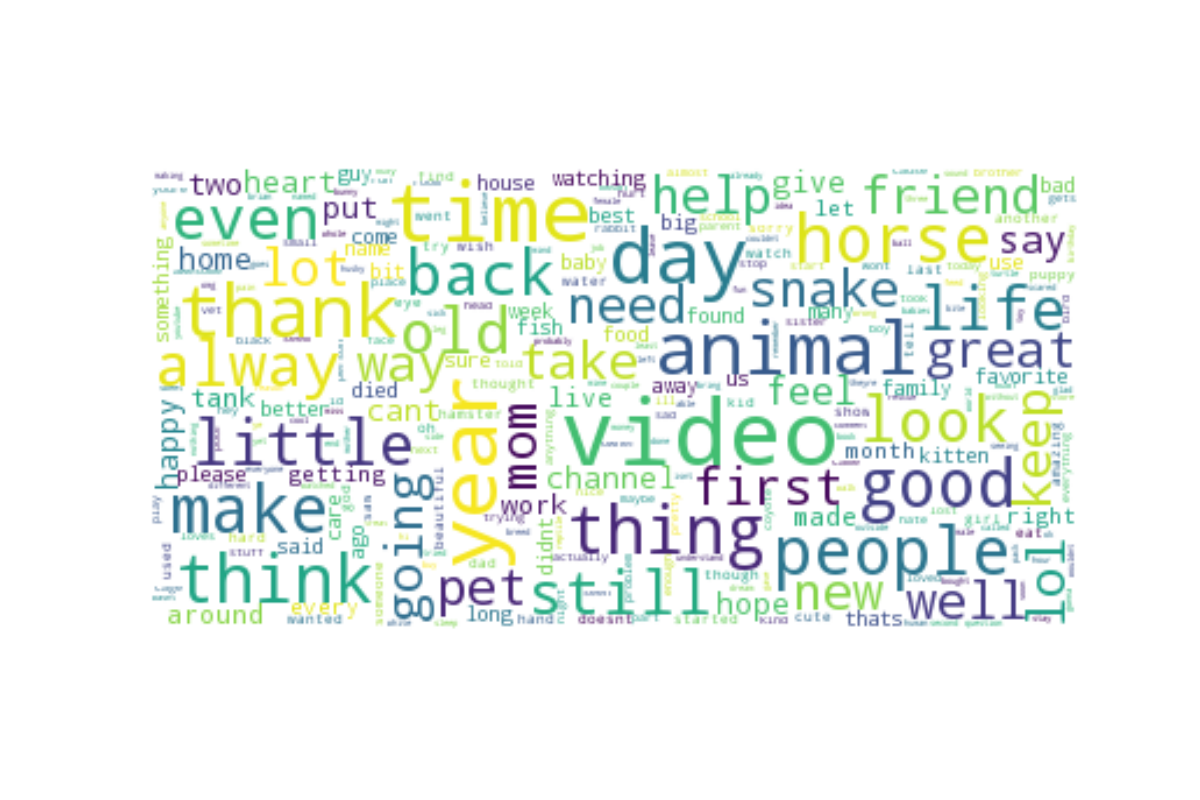

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join([(k + " ")*v for k,v in wc.items()])

wcloud = WordCloud(background_color="white", max_words=20000, collocations = False,
               contour_width=3, contour_color='steelblue',max_font_size=40)

# Generate a word cloud image
wcloud.generate(text)

# Display the generated image:
# the matplotlib way:
fig,ax0=plt.subplots(nrows=1,figsize=(12,8))
ax0.imshow(wcloud,interpolation='bilinear')

ax0.axis("off")
display(fig)

#### 4. Identify Creators With Cat And Dog Owners In The Audience
* Simply filter out all dog and cat owners and aggregate the creators.

In [0]:
#Get all creators whenever the users label is True(cat/dog owner)
df_create = df_pets.select('creator_name').union(pred_all.filter(F.col('prediction') == 1.0).select('creator_name'))

df_create.createOrReplaceTempView("create_table")

#get count
create_count = spark.sql("select distinct creator_name, count(*) as Number\
                          from create_table \
                          group by creator_name \
                          order by Number DESC")

In [0]:
create_count.show()

+--------------------+------+
 creator_name|Number|
+--------------------+------+
 Brave Wilderness| 6867|
 Brian Barczyk| 4500|
 The Dodo| 4125|
 Taylor Nicole Dean| 3910|
Hope For Paws - O...| 1737|
 Cole & Marmalade| 1449|
 Gohan The Husky| 1446|
 Vet Ranch| 1399|
 Robin Seplut| 1349|
 RaleighLink14| 1282|
 Think Like A Horse| 1212|
 stacyvlogs| 1127|
 Viktor Larkhill| 1112|
Zak Georges Dog T...| 1097|
Gone to the Snow ...| 1080|
 HammyLux| 813|
 Talking Kitty Cat| 648|
 Happy Tails| 577|
 Steff J| 548|
 Mr. Max T.V.| 531|
+--------------------+------+
only showing top 20 rows

#### 5. Analysis and Future work   
1. Due to my limited comminity edition computational power, I toke partial of the dataset and downsampling a bit, but definitely want to increat to the whose dataset and run the test, to see the output.   
2. For seeing topic related to onwers, I don't have better ideas than checking out word frequency. We might harness some unsupervised learning techniques here, which I am not that familiar with, need to discuss with Mike.   
3. Tune parameters and do cross-validation. (I skip this part in my word since it's time consuming)